In [1]:
import torch
from utils import *
# Example usage:
from transformers import AutoModelForCausalLM, AutoTokenizer
# model_name = "gpt2"
# model_name = "HuggingFaceTB/SmolLM-360M"
model_name = "HuggingFaceTB/SmolLM-135M"
m_name_save= model_name.replace("/", "_")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_bos_token = True
# batch_size = 512
# batch_size = 32
batch_size =32
max_length = 128
learning_rate = 1e-3
if(model_name == "gpt2"):
    target_layer = 'transformer.h.5'
    d_name = None
else: 
    target_layer = "model.layers.18"
    d_name = "cosmopedia-v2"
debug = True
if(debug):
    if(model_name == "gpt2"):
        dataset_name = "Elriggs/openwebtext-100k"
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
    # num_datapoints = 1_000_000
    num_datapoints = 100_000
    # num_datapoints = 1_000
    total_batches = num_datapoints // batch_size
    print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")
else:    
    if(model_name == "gpt2"):
        dataset_name = "prithivMLmods/OpenWeb888K"
        num_datapoints = 888_000 # 880_000
        total_batches = 888_000 // batch_size
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
        num_datapoints = 2_000_000
        total_batches = num_datapoints // batch_size
        print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")

data_generator = TokenizedDataset(dataset_name, tokenizer, d_name, batch_size=batch_size, max_length=max_length, total_batches=total_batches)

total amount of tokens in dataset: 12.8M


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

# Train SAE offset by 1 batch 
so we don't need to recompute the LLM's activations

# Logan's Attempt

In [2]:
class TemperatureScheduler:
    def __init__(self, 
                 high_temp=1e-3,
                 low_temp=0.0,
                 start_high_fraction=0.2,  # First 20% at high temp
                 end_high_fraction=0.6,    # High temp until 60% of training
                 end_transition_fraction=0.8):  # Low temp from 80% to end
        """
        Temperature scheduler that controls noise injection during training.
        
        Args:
            high_temp: The higher temperature value
            low_temp: The lower temperature value (typically 0)
            start_high_fraction: Fraction of training where temp reaches high_temp
            end_high_fraction: Fraction of training where temp starts to decrease
            end_transition_fraction: Fraction of training where temp reaches low_temp
        """
        self.high_temp = high_temp
        self.low_temp = low_temp
        self.start_high_fraction = start_high_fraction
        self.end_high_fraction = end_high_fraction
        self.end_transition_fraction = end_transition_fraction
        self.current_state = None
        
    def get_temperature(self, current_step, total_steps):
        """
        Calculate the temperature for the current training step.
        
        Args:
            current_step: Current training step (0-indexed)
            total_steps: Total number of training steps
            
        Returns:
            The temperature value for the current step
        """
        # Convert to fraction of total training
        progress = current_step / total_steps
        
        # Phase 1: Ramp up from low_temp to high_temp
        if progress < self.start_high_fraction:
            self.current_state = "ramping_up"
            # Linear interpolation from low_temp to high_temp
            alpha = progress / self.start_high_fraction
            return self.low_temp + (self.high_temp - self.low_temp) * alpha
        
        # Phase 2: Stay at high_temp
        elif progress < self.end_high_fraction:
            self.current_state = "high_temp"
            return self.high_temp
        
        # Phase 3: Ramp down from high_temp to low_temp
        elif progress < self.end_transition_fraction:
            self.current_state = "ramping_down"
            # Linear interpolation from high_temp back to low_temp
            alpha = (progress - self.end_high_fraction) / (self.end_transition_fraction - self.end_high_fraction)
            return self.high_temp - (self.high_temp - self.low_temp) * alpha
        
        # Phase 4: Stay at low_temp until the end
        else:
            self.current_state = "low_temp"
            return self.low_temp

In [3]:
import math
# lots of code used from https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb

dataset_size = num_datapoints* max_length
# beta_star_scalar = dataset_size / math.log(dataset_size) # 1/Temp (From App A)
beta_star_scalar = 1
lr = 1e-4  # "epsilon"
gamma = 0  # Elasticity Regularization (diff from original weights w*)

#temp 5.0e-4 went t. 2.0 & never recovered (also gamm=10)
# Temperature parameters
# max_temp = 2.0e-4
max_temp = 3.0e-4
lowest_temp = 0.0
peak_noise_fraction = 0.1
start_decreasing_fraction = 0.2
stay_at_zero_fraction = 0.3
tempScheduler = TemperatureScheduler(
    max_temp,
    lowest_temp,
    peak_noise_fraction,
    start_decreasing_fraction,
    stay_at_zero_fraction
)

w_0 = (
    torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone()
)
from copy import deepcopy
original_model_copy = deepcopy(model)
all_ce_losses = []
# all_elasticity_losses = []
all_ce_diffs = []
sgd_opt = torch.optim.SGD(model.parameters(), lr=1.0)
adam_opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
restarted_adam=False
for batch_idx in tqdm(range(total_batches)):
    model.zero_grad()
    batch = data_generator.next().to(device)
    with Trace(model, target_layer) as original_trace:
        ce_loss = model(batch, labels=batch).loss
        # x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
        # x = x.detach()

    # w = torch.nn.utils.parameters_to_vector(model.parameters())
    # elasticity_loss = gamma* torch.mean(((w_0 - w) ** 2))
    elasticity_loss = 0.0

    full_loss = lr/2 * (beta_star_scalar*ce_loss + elasticity_loss)
    full_loss.backward()

    if(tempScheduler.current_state == "low_temp" and not restarted_adam):
        # Restart Adam optimizer
        print("Restarting Adam optimizer")
        for state in adam_opt.state.values():
            state.clear()
        adam_opt = torch.optim.Adam(model.parameters(), lr=1e-5)
        restarted_adam = True
    # Choose optimizer based on temperature state
    current_opt = adam_opt if tempScheduler.current_state == "low_temp" else sgd_opt
    current_opt.step()
    # Store losses
    all_ce_losses.append(ce_loss.item())
    # all_elasticity_losses.append(elasticity_loss.item())

    # Add noise to the parameters
    with torch.no_grad():
        if tempScheduler.current_state != "low_temp":
            temperature = tempScheduler.get_temperature(batch_idx, total_batches)
            noise = torch.randn_like(w_0) * temperature
            new_params = torch.nn.utils.parameters_to_vector(model.parameters()) + noise
            torch.nn.utils.vector_to_parameters(new_params, model.parameters())
        if batch_idx % 1 ==0:
            # Check CE diff w/ original model 
            orig_ce_loss = original_model_copy(batch, labels=batch).loss
            ce_diff = ce_loss - orig_ce_loss
            all_ce_diffs.append(ce_diff.item())
    

    if batch_idx % 25 == 0:
    # if batch_idx % 1 == 0:
        # do temp in einsteins notation
        # print(f"Batch {batch_idx}/{total_batches}, Loss: {ce_loss.item():.3f} + {elasticity_loss.item():.5f} | temperature: {temperature:.1e}")
        print(f"Batch {batch_idx}/{total_batches}, CE diff: {ce_diff.item():.3f} | temperature: {temperature:.1e}")
        
print(f"average loss: {torch.tensor(all_ce_losses).mean():.2f}")

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 1/3125 [00:02<2:09:36,  2.49s/it]

Batch 0/3125, CE diff: 0.000 | temperature: 0.0e+00


  1%|          | 26/3125 [00:23<44:23,  1.16it/s] 

Batch 25/3125, CE diff: -0.002 | temperature: 2.4e-05


  2%|▏         | 51/3125 [00:45<44:58,  1.14it/s]

Batch 50/3125, CE diff: -0.003 | temperature: 4.8e-05


  2%|▏         | 76/3125 [01:07<45:22,  1.12it/s]

Batch 75/3125, CE diff: -0.005 | temperature: 7.2e-05


  3%|▎         | 101/3125 [01:30<45:16,  1.11it/s]

Batch 100/3125, CE diff: -0.008 | temperature: 9.6e-05


  4%|▍         | 126/3125 [01:52<45:32,  1.10it/s]

Batch 125/3125, CE diff: -0.004 | temperature: 1.2e-04


  5%|▍         | 151/3125 [02:15<45:24,  1.09it/s]

Batch 150/3125, CE diff: -0.008 | temperature: 1.4e-04


  6%|▌         | 176/3125 [02:38<45:14,  1.09it/s]

Batch 175/3125, CE diff: -0.002 | temperature: 1.7e-04


  6%|▋         | 201/3125 [03:01<44:48,  1.09it/s]

Batch 200/3125, CE diff: -0.001 | temperature: 1.9e-04


  7%|▋         | 226/3125 [03:24<44:32,  1.08it/s]

Batch 225/3125, CE diff: 0.001 | temperature: 2.2e-04


  8%|▊         | 251/3125 [03:47<44:01,  1.09it/s]

Batch 250/3125, CE diff: 0.003 | temperature: 2.4e-04


  9%|▉         | 276/3125 [04:10<44:00,  1.08it/s]

Batch 275/3125, CE diff: 0.008 | temperature: 2.6e-04


 10%|▉         | 301/3125 [04:33<43:19,  1.09it/s]

Batch 300/3125, CE diff: 0.012 | temperature: 2.9e-04


 10%|█         | 326/3125 [04:56<42:55,  1.09it/s]

Batch 325/3125, CE diff: 0.019 | temperature: 3.0e-04


 11%|█         | 351/3125 [05:20<43:01,  1.07it/s]

Batch 350/3125, CE diff: 0.019 | temperature: 3.0e-04


 12%|█▏        | 376/3125 [05:43<42:18,  1.08it/s]

Batch 375/3125, CE diff: 0.025 | temperature: 3.0e-04


 13%|█▎        | 401/3125 [06:06<41:59,  1.08it/s]

Batch 400/3125, CE diff: 0.033 | temperature: 3.0e-04


 14%|█▎        | 426/3125 [06:29<41:29,  1.08it/s]

Batch 425/3125, CE diff: 0.035 | temperature: 3.0e-04


 14%|█▍        | 451/3125 [06:52<40:59,  1.09it/s]

Batch 450/3125, CE diff: 0.037 | temperature: 3.0e-04


 15%|█▌        | 476/3125 [07:15<40:32,  1.09it/s]

Batch 475/3125, CE diff: 0.047 | temperature: 3.0e-04


 16%|█▌        | 501/3125 [07:38<40:23,  1.08it/s]

Batch 500/3125, CE diff: 0.037 | temperature: 3.0e-04


 17%|█▋        | 526/3125 [08:01<39:57,  1.08it/s]

Batch 525/3125, CE diff: 0.056 | temperature: 3.0e-04


 18%|█▊        | 551/3125 [08:24<39:32,  1.08it/s]

Batch 550/3125, CE diff: 0.050 | temperature: 3.0e-04


 18%|█▊        | 576/3125 [08:47<39:01,  1.09it/s]

Batch 575/3125, CE diff: 0.052 | temperature: 3.0e-04


 19%|█▉        | 601/3125 [09:10<38:36,  1.09it/s]

Batch 600/3125, CE diff: 0.051 | temperature: 3.0e-04


 20%|██        | 626/3125 [09:33<38:31,  1.08it/s]

Batch 625/3125, CE diff: 0.062 | temperature: 3.0e-04


 21%|██        | 651/3125 [09:56<37:57,  1.09it/s]

Batch 650/3125, CE diff: 0.066 | temperature: 2.8e-04


 22%|██▏       | 676/3125 [10:19<37:35,  1.09it/s]

Batch 675/3125, CE diff: 0.072 | temperature: 2.5e-04


 22%|██▏       | 701/3125 [10:42<37:10,  1.09it/s]

Batch 700/3125, CE diff: 0.073 | temperature: 2.3e-04


 23%|██▎       | 726/3125 [11:05<36:53,  1.08it/s]

Batch 725/3125, CE diff: 0.078 | temperature: 2.0e-04


 24%|██▍       | 751/3125 [11:28<36:24,  1.09it/s]

Batch 750/3125, CE diff: 0.070 | temperature: 1.8e-04


 25%|██▍       | 776/3125 [11:51<35:58,  1.09it/s]

Batch 775/3125, CE diff: 0.063 | temperature: 1.6e-04


 26%|██▌       | 801/3125 [12:14<35:38,  1.09it/s]

Batch 800/3125, CE diff: 0.079 | temperature: 1.3e-04


 26%|██▋       | 826/3125 [12:37<35:15,  1.09it/s]

Batch 825/3125, CE diff: 0.070 | temperature: 1.1e-04


 27%|██▋       | 851/3125 [13:00<34:47,  1.09it/s]

Batch 850/3125, CE diff: 0.066 | temperature: 8.4e-05


 28%|██▊       | 876/3125 [13:23<34:23,  1.09it/s]

Batch 875/3125, CE diff: 0.070 | temperature: 6.0e-05


 29%|██▉       | 901/3125 [13:46<34:10,  1.08it/s]

Batch 900/3125, CE diff: 0.057 | temperature: 3.6e-05


 30%|██▉       | 926/3125 [14:09<33:44,  1.09it/s]

Batch 925/3125, CE diff: 0.066 | temperature: 1.2e-05


 30%|███       | 939/3125 [14:21<33:41,  1.08it/s]

Restarting Adam optimizer


 30%|███       | 951/3125 [14:33<33:38,  1.08it/s]

Batch 950/3125, CE diff: 0.047 | temperature: 0.0e+00


 31%|███       | 976/3125 [14:56<33:15,  1.08it/s]

Batch 975/3125, CE diff: 0.037 | temperature: 0.0e+00


 32%|███▏      | 1001/3125 [15:19<33:06,  1.07it/s]

Batch 1000/3125, CE diff: 0.039 | temperature: 0.0e+00


 33%|███▎      | 1026/3125 [15:42<32:24,  1.08it/s]

Batch 1025/3125, CE diff: 0.024 | temperature: 0.0e+00


 34%|███▎      | 1051/3125 [16:06<32:13,  1.07it/s]

Batch 1050/3125, CE diff: 0.028 | temperature: 0.0e+00


 34%|███▍      | 1076/3125 [16:29<31:43,  1.08it/s]

Batch 1075/3125, CE diff: 0.020 | temperature: 0.0e+00


 35%|███▌      | 1101/3125 [16:52<31:30,  1.07it/s]

Batch 1100/3125, CE diff: 0.007 | temperature: 0.0e+00


 36%|███▌      | 1126/3125 [17:15<31:01,  1.07it/s]

Batch 1125/3125, CE diff: 0.004 | temperature: 0.0e+00


 37%|███▋      | 1151/3125 [17:39<30:28,  1.08it/s]

Batch 1150/3125, CE diff: 0.018 | temperature: 0.0e+00


 38%|███▊      | 1176/3125 [18:02<30:15,  1.07it/s]

Batch 1175/3125, CE diff: 0.012 | temperature: 0.0e+00


 38%|███▊      | 1201/3125 [18:25<29:46,  1.08it/s]

Batch 1200/3125, CE diff: 0.007 | temperature: 0.0e+00


 39%|███▉      | 1226/3125 [18:48<29:32,  1.07it/s]

Batch 1225/3125, CE diff: 0.017 | temperature: 0.0e+00


 40%|████      | 1251/3125 [19:12<28:52,  1.08it/s]

Batch 1250/3125, CE diff: -0.004 | temperature: 0.0e+00


 41%|████      | 1276/3125 [19:35<28:30,  1.08it/s]

Batch 1275/3125, CE diff: -0.008 | temperature: 0.0e+00


 42%|████▏     | 1301/3125 [19:58<28:38,  1.06it/s]

Batch 1300/3125, CE diff: -0.004 | temperature: 0.0e+00


 42%|████▏     | 1326/3125 [20:21<27:42,  1.08it/s]

Batch 1325/3125, CE diff: 0.001 | temperature: 0.0e+00


 43%|████▎     | 1351/3125 [20:45<27:38,  1.07it/s]

Batch 1350/3125, CE diff: -0.009 | temperature: 0.0e+00


 44%|████▍     | 1376/3125 [21:08<27:08,  1.07it/s]

Batch 1375/3125, CE diff: -0.021 | temperature: 0.0e+00


 45%|████▍     | 1401/3125 [21:31<26:36,  1.08it/s]

Batch 1400/3125, CE diff: -0.005 | temperature: 0.0e+00


 46%|████▌     | 1426/3125 [21:54<26:24,  1.07it/s]

Batch 1425/3125, CE diff: 0.001 | temperature: 0.0e+00


 46%|████▋     | 1451/3125 [22:18<26:15,  1.06it/s]

Batch 1450/3125, CE diff: -0.016 | temperature: 0.0e+00


 47%|████▋     | 1476/3125 [22:41<25:24,  1.08it/s]

Batch 1475/3125, CE diff: -0.009 | temperature: 0.0e+00


 48%|████▊     | 1501/3125 [23:04<25:09,  1.08it/s]

Batch 1500/3125, CE diff: -0.014 | temperature: 0.0e+00


 49%|████▉     | 1526/3125 [23:27<24:57,  1.07it/s]

Batch 1525/3125, CE diff: -0.016 | temperature: 0.0e+00


 50%|████▉     | 1551/3125 [23:51<24:21,  1.08it/s]

Batch 1550/3125, CE diff: -0.024 | temperature: 0.0e+00


 50%|█████     | 1576/3125 [24:14<24:05,  1.07it/s]

Batch 1575/3125, CE diff: -0.006 | temperature: 0.0e+00


 51%|█████     | 1601/3125 [24:37<23:39,  1.07it/s]

Batch 1600/3125, CE diff: -0.013 | temperature: 0.0e+00


 52%|█████▏    | 1626/3125 [25:01<23:26,  1.07it/s]

Batch 1625/3125, CE diff: -0.015 | temperature: 0.0e+00


 53%|█████▎    | 1651/3125 [25:24<22:45,  1.08it/s]

Batch 1650/3125, CE diff: -0.011 | temperature: 0.0e+00


 54%|█████▎    | 1676/3125 [25:47<22:21,  1.08it/s]

Batch 1675/3125, CE diff: -0.024 | temperature: 0.0e+00


 54%|█████▍    | 1701/3125 [26:10<22:05,  1.07it/s]

Batch 1700/3125, CE diff: -0.024 | temperature: 0.0e+00


 55%|█████▌    | 1726/3125 [26:33<21:43,  1.07it/s]

Batch 1725/3125, CE diff: -0.021 | temperature: 0.0e+00


 56%|█████▌    | 1751/3125 [26:57<21:19,  1.07it/s]

Batch 1750/3125, CE diff: -0.020 | temperature: 0.0e+00


 57%|█████▋    | 1776/3125 [27:20<20:46,  1.08it/s]

Batch 1775/3125, CE diff: -0.026 | temperature: 0.0e+00


 58%|█████▊    | 1801/3125 [27:43<20:27,  1.08it/s]

Batch 1800/3125, CE diff: -0.010 | temperature: 0.0e+00


 58%|█████▊    | 1826/3125 [28:06<20:11,  1.07it/s]

Batch 1825/3125, CE diff: -0.037 | temperature: 0.0e+00


 59%|█████▉    | 1851/3125 [28:30<19:46,  1.07it/s]

Batch 1850/3125, CE diff: -0.016 | temperature: 0.0e+00


 60%|██████    | 1876/3125 [28:53<19:20,  1.08it/s]

Batch 1875/3125, CE diff: -0.016 | temperature: 0.0e+00


 61%|██████    | 1901/3125 [29:16<19:01,  1.07it/s]

Batch 1900/3125, CE diff: -0.019 | temperature: 0.0e+00


 62%|██████▏   | 1926/3125 [29:39<18:39,  1.07it/s]

Batch 1925/3125, CE diff: -0.022 | temperature: 0.0e+00


 62%|██████▏   | 1951/3125 [30:03<18:08,  1.08it/s]

Batch 1950/3125, CE diff: -0.009 | temperature: 0.0e+00


 63%|██████▎   | 1976/3125 [30:26<17:51,  1.07it/s]

Batch 1975/3125, CE diff: -0.034 | temperature: 0.0e+00


 64%|██████▍   | 2001/3125 [30:49<17:32,  1.07it/s]

Batch 2000/3125, CE diff: -0.031 | temperature: 0.0e+00


 65%|██████▍   | 2026/3125 [31:12<17:03,  1.07it/s]

Batch 2025/3125, CE diff: -0.027 | temperature: 0.0e+00


 66%|██████▌   | 2051/3125 [31:36<16:41,  1.07it/s]

Batch 2050/3125, CE diff: -0.029 | temperature: 0.0e+00


 66%|██████▋   | 2076/3125 [31:59<16:18,  1.07it/s]

Batch 2075/3125, CE diff: -0.032 | temperature: 0.0e+00


 67%|██████▋   | 2101/3125 [32:22<15:50,  1.08it/s]

Batch 2100/3125, CE diff: -0.026 | temperature: 0.0e+00


 68%|██████▊   | 2126/3125 [32:46<15:30,  1.07it/s]

Batch 2125/3125, CE diff: -0.016 | temperature: 0.0e+00


 69%|██████▉   | 2151/3125 [33:09<15:06,  1.07it/s]

Batch 2150/3125, CE diff: -0.031 | temperature: 0.0e+00


 70%|██████▉   | 2176/3125 [33:32<14:44,  1.07it/s]

Batch 2175/3125, CE diff: -0.024 | temperature: 0.0e+00


 70%|███████   | 2201/3125 [33:56<14:22,  1.07it/s]

Batch 2200/3125, CE diff: -0.018 | temperature: 0.0e+00


 71%|███████   | 2226/3125 [34:19<13:53,  1.08it/s]

Batch 2225/3125, CE diff: -0.033 | temperature: 0.0e+00


 72%|███████▏  | 2251/3125 [34:42<13:31,  1.08it/s]

Batch 2250/3125, CE diff: -0.026 | temperature: 0.0e+00


 73%|███████▎  | 2276/3125 [35:05<13:06,  1.08it/s]

Batch 2275/3125, CE diff: -0.043 | temperature: 0.0e+00


 74%|███████▎  | 2301/3125 [35:28<12:46,  1.07it/s]

Batch 2300/3125, CE diff: -0.044 | temperature: 0.0e+00


 74%|███████▍  | 2326/3125 [35:52<12:22,  1.08it/s]

Batch 2325/3125, CE diff: -0.036 | temperature: 0.0e+00


 75%|███████▌  | 2351/3125 [36:15<11:57,  1.08it/s]

Batch 2350/3125, CE diff: -0.027 | temperature: 0.0e+00


 76%|███████▌  | 2376/3125 [36:38<11:34,  1.08it/s]

Batch 2375/3125, CE diff: -0.026 | temperature: 0.0e+00


 77%|███████▋  | 2401/3125 [37:01<11:12,  1.08it/s]

Batch 2400/3125, CE diff: -0.023 | temperature: 0.0e+00


 78%|███████▊  | 2426/3125 [37:25<10:50,  1.07it/s]

Batch 2425/3125, CE diff: -0.020 | temperature: 0.0e+00


 78%|███████▊  | 2451/3125 [37:48<10:28,  1.07it/s]

Batch 2450/3125, CE diff: -0.033 | temperature: 0.0e+00


 79%|███████▉  | 2476/3125 [38:11<10:08,  1.07it/s]

Batch 2475/3125, CE diff: -0.046 | temperature: 0.0e+00


 80%|████████  | 2501/3125 [38:35<09:44,  1.07it/s]

Batch 2500/3125, CE diff: -0.037 | temperature: 0.0e+00


 81%|████████  | 2526/3125 [38:58<09:16,  1.08it/s]

Batch 2525/3125, CE diff: -0.032 | temperature: 0.0e+00


 82%|████████▏ | 2551/3125 [39:21<08:53,  1.08it/s]

Batch 2550/3125, CE diff: -0.034 | temperature: 0.0e+00


 82%|████████▏ | 2576/3125 [39:45<08:31,  1.07it/s]

Batch 2575/3125, CE diff: -0.037 | temperature: 0.0e+00


 83%|████████▎ | 2601/3125 [40:08<08:09,  1.07it/s]

Batch 2600/3125, CE diff: -0.041 | temperature: 0.0e+00


 84%|████████▍ | 2626/3125 [40:31<07:47,  1.07it/s]

Batch 2625/3125, CE diff: -0.038 | temperature: 0.0e+00


 85%|████████▍ | 2651/3125 [40:55<07:22,  1.07it/s]

Batch 2650/3125, CE diff: -0.025 | temperature: 0.0e+00


 86%|████████▌ | 2676/3125 [41:18<06:59,  1.07it/s]

Batch 2675/3125, CE diff: -0.051 | temperature: 0.0e+00


 86%|████████▋ | 2701/3125 [41:42<06:34,  1.07it/s]

Batch 2700/3125, CE diff: -0.055 | temperature: 0.0e+00


 87%|████████▋ | 2726/3125 [42:05<06:14,  1.07it/s]

Batch 2725/3125, CE diff: -0.036 | temperature: 0.0e+00


 88%|████████▊ | 2751/3125 [42:28<05:49,  1.07it/s]

Batch 2750/3125, CE diff: -0.042 | temperature: 0.0e+00


 89%|████████▉ | 2776/3125 [42:52<05:26,  1.07it/s]

Batch 2775/3125, CE diff: -0.053 | temperature: 0.0e+00


 90%|████████▉ | 2801/3125 [43:15<05:01,  1.07it/s]

Batch 2800/3125, CE diff: -0.041 | temperature: 0.0e+00


 90%|█████████ | 2826/3125 [43:39<04:39,  1.07it/s]

Batch 2825/3125, CE diff: -0.041 | temperature: 0.0e+00


 91%|█████████ | 2851/3125 [44:02<04:15,  1.07it/s]

Batch 2850/3125, CE diff: -0.042 | temperature: 0.0e+00


 92%|█████████▏| 2876/3125 [44:25<03:55,  1.06it/s]

Batch 2875/3125, CE diff: -0.056 | temperature: 0.0e+00


 93%|█████████▎| 2901/3125 [44:49<03:28,  1.07it/s]

Batch 2900/3125, CE diff: -0.038 | temperature: 0.0e+00


 94%|█████████▎| 2926/3125 [45:12<03:04,  1.08it/s]

Batch 2925/3125, CE diff: -0.038 | temperature: 0.0e+00


 94%|█████████▍| 2951/3125 [45:35<02:43,  1.07it/s]

Batch 2950/3125, CE diff: -0.035 | temperature: 0.0e+00


 95%|█████████▌| 2976/3125 [45:59<02:19,  1.07it/s]

Batch 2975/3125, CE diff: -0.049 | temperature: 0.0e+00


 96%|█████████▌| 3001/3125 [46:22<01:56,  1.06it/s]

Batch 3000/3125, CE diff: -0.037 | temperature: 0.0e+00


 97%|█████████▋| 3026/3125 [46:45<01:32,  1.07it/s]

Batch 3025/3125, CE diff: -0.034 | temperature: 0.0e+00


 98%|█████████▊| 3051/3125 [47:09<01:09,  1.06it/s]

Batch 3050/3125, CE diff: -0.046 | temperature: 0.0e+00


 98%|█████████▊| 3076/3125 [47:32<00:45,  1.08it/s]

Batch 3075/3125, CE diff: -0.020 | temperature: 0.0e+00


 99%|█████████▉| 3101/3125 [47:56<00:22,  1.07it/s]

Batch 3100/3125, CE diff: -0.039 | temperature: 0.0e+00


100%|██████████| 3125/3125 [48:18<00:00,  1.08it/s]

average loss: 1.55


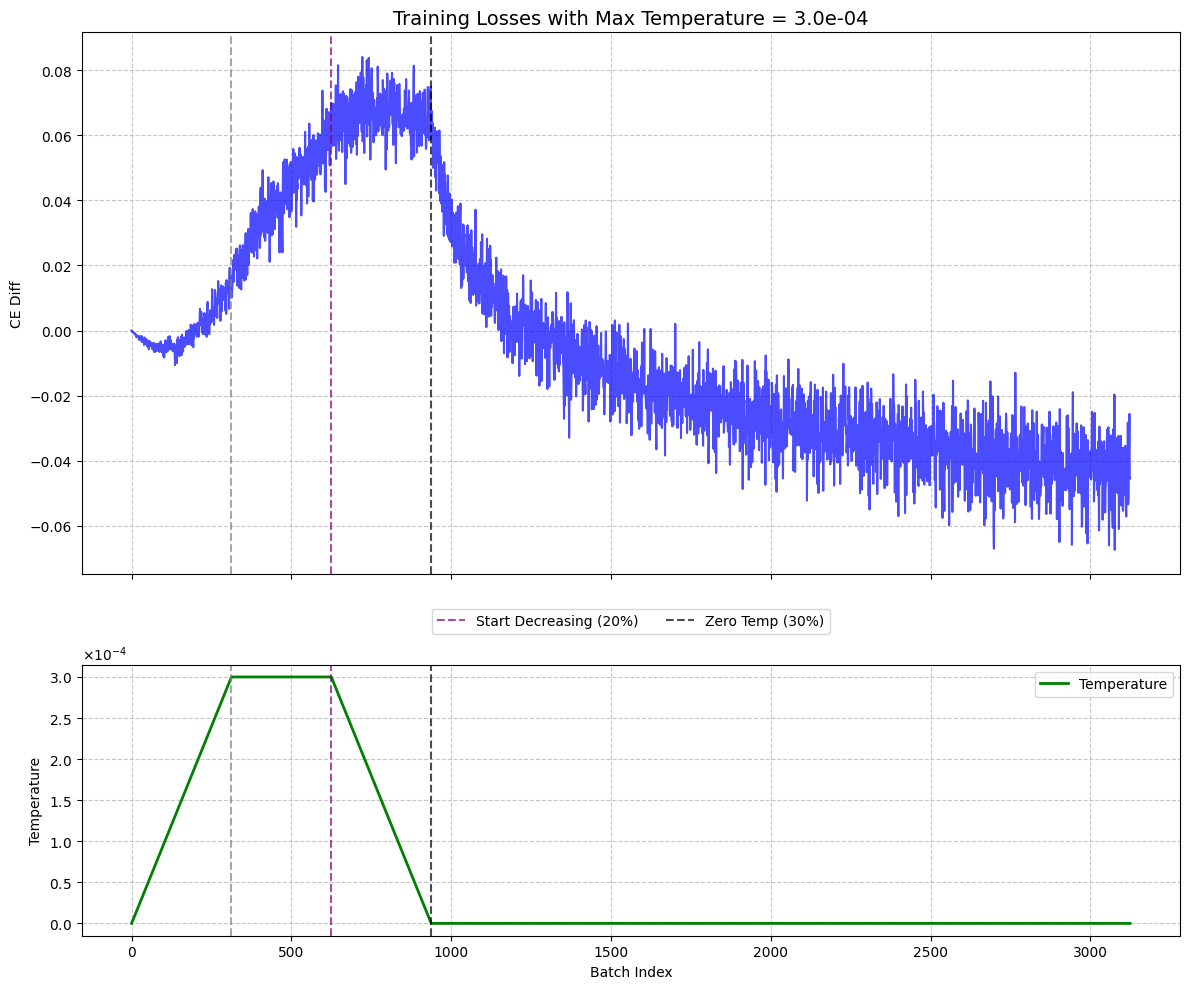

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


# Generate sample data for demonstration
n = 1
t_ce_losses = torch.tensor(all_ce_losses)
t_ce_losses.shape # [3125]
pooled = F.avg_pool1d(t_ce_losses.reshape(1, 1, -1), kernel_size=n, stride=n).squeeze().squeeze()
# total_batches = 3125

# batch_indices = np.arange(total_batches // n)  # Adjusted for the pooled data
batch_indices = np.arange(len(all_ce_diffs))  # Adjusted for the pooled data

# Generate temperature values for each batch
temperatures = [tempScheduler.get_temperature(i, total_batches) for i in batch_indices]

# Create a figure with two subplots sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the losses on the first subplot
# ax1.plot(batch_indices, pooled, label='CE Loss', color='blue', alpha=0.7)
ax1.plot(batch_indices, all_ce_diffs, label='CE Loss', color='blue', alpha=0.7)
# ax1.plot(batch_indices, all_elasticity_losses, label='Elasticity Loss', color='red', alpha=0.7)
ax1.set_ylabel('CE Diff')
ax1.set_title(f'Training Losses with Max Temperature = {max_temp:.1e}', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot the temperature schedule on the second subplot
temp_batch_indices = np.arange(len(temperatures))
ax2.plot(temp_batch_indices, temperatures, label='Temperature', color='green', linewidth=2)
ax2.set_ylabel('Temperature')
ax2.set_xlabel('Batch Index')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Use scientific notation for y-axis in the temperature subplot
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Add vertical lines to show the different phases of temperature
peak_idx = int(peak_noise_fraction * total_batches)
decrease_idx = int(start_decreasing_fraction * total_batches)
zero_idx = int(stay_at_zero_fraction * total_batches)

for ax in [ax1, ax2]:
    ax.axvline(x=peak_idx, color='gray', linestyle='--', alpha=0.7, 
              label=f'Peak Noise ({peak_noise_fraction*100:.0f}%)')
    ax.axvline(x=decrease_idx, color='purple', linestyle='--', alpha=0.7, 
              label=f'Start Decreasing ({start_decreasing_fraction*100:.0f}%)')
    ax.axvline(x=zero_idx, color='black', linestyle='--', alpha=0.7, 
              label=f'Zero Temp ({stay_at_zero_fraction*100:.0f}%)')

# Add a legend for the vertical lines on the first subplot only
handles, labels = ax1.get_legend_handles_labels()
phase_handles = handles[2:]  # Get only the vertical line handles
phase_labels = labels[2:]    # Get only the vertical line labels
ax1.legend(handles[:2], labels[:2], loc='upper right')  # Loss lines legend
leg = ax1.legend(phase_handles, phase_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=3, frameon=True)

plt.tight_layout()
# save the plt figure
plt.show()

In [ ]:
# save figure
# fig.savefig(f"figures/{m_name_save}_temp_schedule.png", bbox_inches='tight', dpi=300)
# need to use plt
# save figure
plt.savefig(f"figures/{m_name_save}_temp_schedule.png", dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

In [5]:
plt.show()

In [ ]:
import math
# lots of code used from https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb

dataset_size = num_datapoints* max_length
# beta_star_scalar = dataset_size / math.log(dataset_size) # 1/Temp (From App A)
beta_star_scalar = 1
lr = 1e-4  # "epsilon"
gamma = 0  # Elasticity Regularization (diff from original weights w*)

#temp 5.0e-4 went t. 2.0 & never recovered (also gamm=10)
# Temperature parameters
max_temp = 2.0e-4
lowest_temp = 0.0
peak_noise_fraction = 0.1
start_decreasing_fraction = 0.5
stay_at_zero_fraction = 0.6
tempScheduler = TemperatureScheduler(
    max_temp,
    lowest_temp,
    peak_noise_fraction,
    start_decreasing_fraction,
    stay_at_zero_fraction
)

w_0 = (
    torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone().to(device)
)

def custom_topk_encode(x, sae, feature_ids):
    post_relu_feat_acts_BF = nn.functional.relu(sae.encoder(x - sae.b_dec))
    # get the activations at the feature_ids (feature_ids is = to top_indices_BK)
    custom_feature_acts = post_relu_feat_acts_BF[:, feature_ids]
    return custom_feature_acts
    # post_topk = post_relu_feat_acts_BF.topk(sae.k, sorted=False, dim=-1)

    # # We can't split immediately due to nnsight
    # tops_acts_BK = post_topk.values
    # top_indices_BK = post_topk.indices

    # buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
    # encoded_acts_BF = buffer_BF.scatter_(dim=-1, index=top_indices_BK, src=tops_acts_BK)

all_ce_losses = []
all_ce_diffs = []
all_elasticity_losses = []
opt = torch.optim.SGD(model.parameters(), lr=1)
for batch_idx in tqdm(range(total_batches)):
    model.zero_grad()
    batch = data_generator.next().to(device)
    with Trace(model, target_layer) as original_trace:
        ce_loss = model(batch, labels=batch).loss
        x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
        x = x.detach()

    w = torch.nn.utils.parameters_to_vector(model.parameters())
    elasticity_loss = gamma* torch.mean(((w_0 - w) ** 2))

    full_loss = lr/2 * (beta_star_scalar*ce_loss + elasticity_loss)
    full_loss.backward()
    opt.step()

    # Store losses
    all_ce_losses.append(ce_loss.item())
    all_elasticity_losses.append(elasticity_loss.item())

    # Add noise to the parameters
    with torch.no_grad():
        temperature = tempScheduler.get_temperature(batch_idx, total_batches)
        noise = torch.randn_like(w) * temperature
        new_params = torch.nn.utils.parameters_to_vector(model.parameters()) + noise
        torch.nn.utils.vector_to_parameters(new_params, model.parameters())
    
    if batch_idx % 25 == 0:
        # do temp in einsteins notation
        print(f"Batch {batch_idx}/{total_batches}, Loss: {ce_loss.item():.3f} + {elasticity_loss.item():.5f} | temperature: {temperature:.1e}")

    # SAE sims
    with torch.no_grad():
        # we also want the original model's SA,E features
        # TODO: include token-SAE part, also normalize
        with Trace(original_model, target_layer) as original_trace:
            original_ce_loss = original_model(batch, labels=batch).loss
            old_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
            old_x = old_x.detach()
        all_ce_diffs.append(original_ce_loss.item() - ce_loss.item())
        # old_x = old_x normalized

        # per_token_bias = sae.

        _, local_mags, local_ids = old_sae.encode(old_x, return_topk=True)

        new_x = x normalized
        per_token_bias = new_sae.per_token_bias(new_x)
        new_features = new_sae.encode(new_x, return_topk=True)        

        # Find diff of existing features, avg across existing features
        per_feature_MSE = # local_mags - new_features**2

        # combine over the local_ids that are the same into our global one





    
        
print(f"average loss: {torch.tensor(all_ce_losses).mean():.2f}")

In [4]:
t_ce_losses = torch.tensor(all_ce_losses)
n = 3
pooled = F.avg_pool1d(t_ce_losses, kernel_size=n, stride=n)
print(pooled.shape)

# pooled = F.avg_pool1d(t_ce_losses, kernel_size=n, stride=2)
# print(pooled.shape)

# pooled = F.avg_pool1d(t_ce_losses, kernel_size=n, stride=1)
# print(pooled.shape)

RuntimeError: Expected 2 to 3 dimensions, but got 1-dimensional tensor for argument #1 'self' (while checking arguments for avg_pool1d)

In [10]:
t_ce_losses.shape # [3125]
pooled = F.avg_pool1d(t_ce_losses.reshape(1, 1, -1), kernel_size=n, stride=n)
print(pooled.shape) # [1, 1, 1042.shape, ]
pooled[:, :, :2], t_ce_losses[:6]

torch.Size([1, 1, 1041])


(tensor([[[1.5274, 1.4852]]]),
 tensor([1.5175, 1.5530, 1.5116, 1.4275, 1.5783, 1.4497]))

In [16]:
t_ce_losses[:100].mean(), t_ce_losses[-100:].mean()

(tensor(1.5539), tensor(1.6119))

# Various Losses (underestimate since the first 1/5 are ~ normal loss)
no optimization: 1.55
temp: CE
0.0: 1.55
1e-3: 1.59 (Prolly more like 1.6?)
1.5e-3: (lead to 3+ CE loss)
3e-3: 1.87 (probably more like 2.3?)
1e-2: 7.56
1e-1: 

# Paper's version

In [ ]:

# Original Implementation for posterity
import math
# lots of code used from https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb

dataset_size = num_datapoints* max_length
# beta_star_scalar = dataset_size / math.log(dataset_size) # 1/Temp (From App A)
beta_star_scalar = 1000
lr = 1e-5  # "epsilon"
gamma = 100  # Elasticity Regularization (diff from original weights w*)


w_0 = (
    torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone().to(device)
)

all_ce_losses = []
opt = torch.optim.SGD(model.parameters(), lr=1)
for batch_idx in tqdm(range(total_batches)):
    model.zero_grad()
    batch = data_generator.next().to(device)
    with Trace(model, target_layer) as original_trace:
        ce_loss = model(batch, labels=batch).loss
        # x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
        # x = x.detach()
    all_ce_losses.append(ce_loss.item())
    print(f"Batch {batch_idx}/{total_batches}, Loss: {ce_loss.item()}")

    w = torch.nn.utils.parameters_to_vector(model.parameters())
    elasticity_loss = gamma* torch.sum(((w_0 - w) ** 2))

    full_loss = lr/2 * (beta_star_scalar*ce_loss + elasticity_loss)
    full_loss.backward()
    opt.step()

    # Add noise to the parameters
    with torch.no_grad():
        noise = torch.randn_like(w) * math.sqrt(lr)
        new_params = torch.nn.utils.parameters_to_vector(model.parameters()) + noise
        torch.nn.utils.vector_to_parameters(new_params, model.parameters())
    
    if batch_idx+1 % 100 == 0:
        break

  0%|          | 0/31 [00:00<?, ?it/s]

Batch 0/31, Loss: 1.5174819231033325


  3%|▎         | 1/31 [00:02<01:06,  2.22s/it]

Batch 1/31, Loss: 1.5940889120101929


  6%|▋         | 2/31 [00:02<00:37,  1.30s/it]

Batch 2/31, Loss: 1.5510947704315186


 10%|▉         | 3/31 [00:03<00:28,  1.01s/it]

Batch 3/31, Loss: 1.4830965995788574


 13%|█▎        | 4/31 [00:04<00:23,  1.17it/s]

Batch 4/31, Loss: 1.6588068008422852


 16%|█▌        | 5/31 [00:04<00:20,  1.28it/s]

Batch 5/31, Loss: 1.5391548871994019


 19%|█▉        | 6/31 [00:05<00:18,  1.38it/s]

Batch 6/31, Loss: 1.6503872871398926


 23%|██▎       | 7/31 [00:06<00:16,  1.45it/s]

Batch 7/31, Loss: 1.6916022300720215


 26%|██▌       | 8/31 [00:06<00:15,  1.50it/s]

Batch 8/31, Loss: 1.735732078552246


 29%|██▉       | 9/31 [00:07<00:14,  1.53it/s]

Batch 9/31, Loss: 1.7128238677978516


 32%|███▏      | 10/31 [00:07<00:13,  1.56it/s]

Batch 10/31, Loss: 1.6279575824737549


 35%|███▌      | 11/31 [00:08<00:12,  1.58it/s]

Batch 11/31, Loss: 1.749906301498413


 39%|███▊      | 12/31 [00:09<00:11,  1.59it/s]

Batch 12/31, Loss: 1.773111343383789


 42%|████▏     | 13/31 [00:09<00:11,  1.61it/s]

Batch 13/31, Loss: 1.6503177881240845


 45%|████▌     | 14/31 [00:10<00:10,  1.60it/s]

Batch 14/31, Loss: 1.7286254167556763


 48%|████▊     | 15/31 [00:11<00:10,  1.57it/s]

Batch 15/31, Loss: 1.7342747449874878


 52%|█████▏    | 16/31 [00:11<00:09,  1.56it/s]

Batch 16/31, Loss: 1.8550516366958618


 55%|█████▍    | 17/31 [00:12<00:09,  1.55it/s]

Batch 17/31, Loss: 1.7659858465194702


 58%|█████▊    | 18/31 [00:12<00:08,  1.56it/s]

Batch 18/31, Loss: 1.846542477607727


 61%|██████▏   | 19/31 [00:13<00:07,  1.56it/s]

Batch 19/31, Loss: 1.8334592580795288


 65%|██████▍   | 20/31 [00:14<00:07,  1.56it/s]

Batch 20/31, Loss: 1.8509552478790283


 68%|██████▊   | 21/31 [00:14<00:06,  1.56it/s]

Batch 21/31, Loss: 1.8666054010391235


 71%|███████   | 22/31 [00:15<00:05,  1.54it/s]

Batch 22/31, Loss: 1.8199610710144043


 74%|███████▍  | 23/31 [00:16<00:05,  1.57it/s]

Batch 23/31, Loss: 1.8627246618270874


 77%|███████▋  | 24/31 [00:16<00:04,  1.58it/s]

Batch 24/31, Loss: 1.824777364730835


 81%|████████  | 25/31 [00:17<00:03,  1.58it/s]

Batch 25/31, Loss: 1.9027161598205566


 84%|████████▍ | 26/31 [00:18<00:03,  1.59it/s]

Batch 26/31, Loss: 1.9247510433197021


 87%|████████▋ | 27/31 [00:18<00:02,  1.60it/s]

Batch 27/31, Loss: 2.0149049758911133


 90%|█████████ | 28/31 [00:19<00:01,  1.60it/s]

Batch 28/31, Loss: 1.9189292192459106


 94%|█████████▎| 29/31 [00:19<00:01,  1.60it/s]

Batch 29/31, Loss: 1.8826706409454346


 97%|█████████▋| 30/31 [00:20<00:00,  1.60it/s]

Batch 30/31, Loss: 1.8817261457443237


100%|██████████| 31/31 [00:21<00:00,  1.47it/s]


In [ ]:
beta_star_scalar

10884.55223379998

In [ ]:
grad_scale, beta_star

(10884.55223379998, 0.08503556432656234)

In [ ]:
all_ce_losses

[1.5174819231033325,
 13.509295463562012,
 10730.595703125,
 59638848.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

# Older code

In [ ]:

# Original Implementation for posterity
import math
dataset_size = num_datapoints* max_length
beta_star = 1 / math.log(dataset_size) # 1/Temp (From App A)
lr = 1e-3  # "epsilon"
gamma = 1  # Elasticity Regularization (diff from original weights w*)

# store initial weights
model.optimal_weights = {}
for name, param in model.named_parameters():
    model.optimal_weights[name] = param.data.clone()

for batch_idx in tqdm(range(total_batches)):
    model.zero_grad()
    batch = data_generator.next().to(device)
    
    outputs = model(batch, labels=batch)
    loss = outputs.loss
    loss.backward()

    # Apply SGLD update
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is not None:
                # Generate Gaussian noise (line 7)
                noise = torch.randn_like(param.data) * math.sqrt(lr)
                
                # Compute elasticity term: gamma * (w* - w)
                elasticity_loss = gamma * (model.optimal_weights[name] - param.data)
                
                # Gradient scaling
                grad_scale = dataset_size * beta_star
                
                # Apply update
                param.data += (lr/2) * (grad_scale * param.grad + elasticity_loss) + noise
    
    if batch_idx+1 % 100 == 0:
        break
    #     print(f"Batch {batch_idx}/{num_iterations}, Loss: {loss.item()}")

100%|██████████| 31/31 [00:20<00:00,  1.53it/s]


128k d_point in 20 sec: 1M in 4 min 10M in 40m